In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import cv2
import os
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import tqdm
import torch.nn.functional as F

c:\Users\Priya\Documents\Projects\DL\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [55]:
im = Image.open('C:/Users/Priya/Documents/Projects/DL/Datasets/RITE/training/images/40_training.tif')
# im.show()

In [56]:
imarray = np.array(im)

In [175]:
shape = imarray.shape
shape

(584, 565, 3)

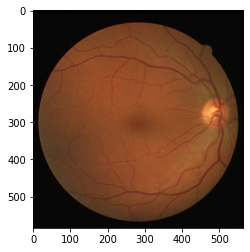

In [57]:
plt.imshow(imarray, cmap="gray")

In [3]:
data_path = 'C:/Users/Priya/Documents/Projects/DL/Datasets/RITE/'
train_images = 'training/images/'
train_masks = 'training/vessel/'
test_images = 'test/images/'
test_masks = 'test/vessel/'
valid_images = 'validation/images/'
valid_masks = 'validation/masks/'

In [4]:
train_X = sorted(glob.glob(os.path.join(data_path + train_images + '*.tif')))
train_y = sorted(glob.glob(os.path.join(data_path + train_masks + '*.png')))

test_X = sorted(glob.glob(os.path.join(data_path + test_images + '*.tif')))
test_y = sorted(glob.glob(os.path.join(data_path + test_masks + '*.png')))

valid_X = sorted(glob.glob(os.path.join(data_path + valid_images + '*.tif')))
valid_y = sorted(glob.glob(os.path.join(data_path + valid_masks + '*.png')))

In [42]:
len(train_X)

20

In [43]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
])

In [45]:
# dataset = torchvision.datasets.ImageFolder(data_path + 'training', transform=transforms)

In [5]:
def data_augmentation(images, masks, path):
    id = 0
    augHorizontal = HorizontalFlip(p=1.0)
    augVertical = VerticalFlip(p=1.0)
    augRotate = Rotate(limit=45, p=1.0)
    for idx, (x, y) in tqdm.tqdm(enumerate(zip(images, masks)), total = len(images)):
        x = np.array(Image.open(x))
        y = np.array(Image.open(y))

        imgHorizontal = augHorizontal(image=x, mask=y)
        imgVertical = augVertical(image=x, mask=y)
        imgRotate = augRotate(image=x, mask=y)

        X = [x, imgHorizontal['image'], imgVertical['image'], imgRotate['image']]
        Y = [y, imgHorizontal['mask'], imgVertical['mask'], imgRotate['mask']]

        for i, m in zip(X, Y):
            tmp_img_name = f"{id}.png"
            tmp_mask_name = f"{id}.png"

            image_path = os.path.join(path,'images/', tmp_img_name)
            mask_path = os.path.join(path,'masks/', tmp_mask_name)

            Image.fromarray(i).resize(size=(512, 512)).save(image_path)
            Image.fromarray(m).resize(size=(512, 512)).save(mask_path)

            id += 1
        
        

In [6]:
def test_data_augmentation(images, masks, path):
    id = 0
    for idx, (x, y) in tqdm.tqdm(enumerate(zip(images, masks)), total = len(images)):
        x = np.array(Image.open(x))
        y = np.array(Image.open(y))
        
        tmp_img_name = f"{id}.png"
        tmp_mask_name = f"{id}.png"
        
        image_path = os.path.join(path,'images/', tmp_img_name)
        mask_path = os.path.join(path,'masks/', tmp_mask_name)

        Image.fromarray(x).resize(size=(512, 512)).save(image_path)
        Image.fromarray(y).resize(size=(512, 512)).save(mask_path)

        id += 1

In [7]:

data_augmentation(train_X, train_y, 'RITE/train/')


100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


In [8]:
test_data_augmentation(test_X, test_y, 'RITE/test/')

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


In [9]:
test_data_augmentation(valid_X, valid_y, 'RITE/validation/')

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


In [6]:
class conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
    
    def forward(self, images):
        x = self.conv1(images)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x


In [7]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, images):
        x = self.conv(images)
        p = self.pool(x)

        return x, p

In [8]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = conv(out_channels * 2, out_channels)

    def forward(self, images, prev):
        x = self.upconv(images)
        x = torch.cat([x, prev], axis=1)
        x = self.conv(x)

        return x


In [9]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder(3, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        self.b = conv(512, 1024)

        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, images):
        x1, p1 = self.e1(images)
        x2, p2 = self.e2(p1)
        x3, p3 = self.e3(p2)
        x4, p4 = self.e4(p3)

        b = self.b(p4)
        
        d1 = self.d1(b, x4)
        d2 = self.d2(d1, x3)
        d3 = self.d3(d2, x2)
        d4 = self.d4(d3, x1)

        output_mask = self.output(d4)

        return output_mask      

In [10]:
a = torch.randn((2, 3, 512, 512))
f = UNet()
b = f(a)

In [217]:
b.shape

torch.Size([2, 1, 512, 512])

In [11]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        img = np.transpose(img, (2, 0, 1))
        img = img/255
        img = torch.tensor(img)

        mask = Image.open(self.masks_path[idx]).convert('L')
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [12]:
train_X = sorted(glob.glob('./RITE/train/images/*'))
train_y = sorted(glob.glob('./RITE/train/masks/*'))

test_X = sorted(glob.glob('./RITE/test/images/*'))
test_y = sorted(glob.glob('./RITE/test/masks/*'))

valid_X = sorted(glob.glob('./RITE/validation/images/*'))
valid_y = sorted(glob.glob('./RITE/validation/masks/*'))

In [13]:
len(test_X)

10

In [14]:
H = 512
W = 512
size = (H, W)
batch_size = 2
num_epochs = 50
lr = 1e-4


train_dataset = LoadData(train_X, train_y)
valid_dataset = LoadData(valid_X, valid_y)


In [15]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
)

In [32]:
device = torch.device('cuda')
model = UNet()
# model = model.to(device)

In [33]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [35]:
def train_model(model, loader, optimizer, loss_fn, device):
    torch.cuda.empty_cache()
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        # x = x.to(device, dtype=torch.float32)
        # y = y.to(device, dtype=torch.float32)
        x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(loss.item())

    epoch_loss = epoch_loss/len(loader)
    torch.cuda.empty_cache()
    return epoch_loss

In [36]:
def evaluate(model, loader, loss_fn, device):
    torch.cuda.empty_cache()
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            # x = x.to(device, dtype=torch.float32)
            # y = y.to(device, dtype=torch.float32)
            x,y=x.type(torch.DoubleTensor),y.type(torch.DoubleTensor)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            print("valid loss", loss)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
        torch.cuda.empty_cache()
    return epoch_loss

In [37]:
torch.cuda.empty_cache()

In [38]:
train = []
valid = []
for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train.append(train_loss)
        valid.append(valid_loss)        

        data_str = f'Epoch: {epoch+1:02}'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        print(data_str)

1.365056037902832
1.3042171001434326
1.315916895866394
1.1671783924102783
1.0955440998077393
1.092761516571045
1.0635900497436523
1.1575660705566406
1.018336534500122
1.0640348196029663
1.0353970527648926
1.1416990756988525
1.1820485591888428
1.0331504344940186
1.189998984336853
1.0755032300949097
1.1240785121917725
1.0398000478744507
1.1762232780456543
0.9995113611221313
0.9934054017066956
1.0007845163345337
1.0490076541900635
0.9725736975669861


KeyboardInterrupt: 